In [ ]:
!pip install -q git+https://github.com/tensorflow/docs

  Preparing metadata (setup.py) ... done


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
from keras import models
from keras.models import Sequential
from keras.layers import LSTM, TimeDistributed, Dense, ConvLSTM2D, MultiHeadAttention, Flatten, MaxPooling3D

import os
import random
from pathlib import Path
import imageio
from IPython import display
from urllib import request
from tensorflow_docs.vis import embed

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
DIR = "drive/MyDrive/dataset"

In [ ]:
# cek
os.listdir(DIR)

['train', 'val']

In [ ]:
print("file train/fight: ",len(os.listdir(DIR+"/train/Fight")))
print("file train/nonfight:", len(os.listdir(DIR+"/train/NonFight")))
print("file val/fight: ", len(os.listdir(DIR+"/val/Fight")))
print("file val/nonfight: ", len(os.listdir(DIR+"/val/NonFight")))

file train/fight:  800
file train/nonfight: 800
file val/fight:  200
file val/nonfight:  200


In [ ]:
class FrameGenerator:
    def __init__(self, path, training=False):
        """ Returns a set of frames with their associated label.
          Args:
            path: Video file paths.
            n_frames: Number of frames.
            training: Boolean to determine if training dataset is being created.
        """
        self.path = path

        self.training = training
        self.class_names = ['NonFight', 'Fight']
        self.class_ids_for_name = dict((name, idx) for idx, name in enumerate(self.class_names))

    def get_files_and_class_names(self):
        if self.training:
            fight_paths = list(self.path.glob('Fight/*.npy'))
            nonfight_paths = list(self.path.glob('NonFight/*.npy'))

            fight_paths = random.choices(fight_paths, k=200)
            nonfight_paths = random.choices(nonfight_paths, k=200)
        else:
            fight_paths = list(self.path.glob('Fight/*.npy'))
            nonfight_paths = list(self.path.glob('NonFight/*.npy'))

            fight_paths = random.choices(fight_paths, k=40)
            nonfight_paths = random.choices(nonfight_paths, k=40)

        # if self.training:
        #     video_paths = list(self.path.glob('Fight/*.npy')) + list(self.path.glob('NonFight/*.npy'))
        # else:
        #     video_paths = list(self.path.glob('Fight/*.npy')) + list(self.path.glob('NonFight/*.npy'))
        # classes = [p.parent.name for p in video_paths]

        video_paths = fight_paths + nonfight_paths
        classes = [p.parent.name for p in video_paths]

        return video_paths, classes

    def __call__(self):
        video_paths, classes = self.get_files_and_class_names()

        pairs = list(zip(video_paths, classes))

        if self.training:
            random.shuffle(pairs)

        for path, name in pairs:
            video_frames = self.read_npy_file(path)
            label = self.class_ids_for_name[name]
            yield video_frames, label


    def read_npy_file(self, path):
        data = np.load(path)
        data = np.float32(data)
        data = data/255.0
        return data

In [ ]:
train_file = Path(DIR).joinpath("train").with_suffix('')
test_file = Path(DIR).joinpath("val").with_suffix('')
train_file

PosixPath('drive/MyDrive/dataset/train')

In [ ]:
fg = FrameGenerator(train_file, training=True)

# test
frames, label = next(fg())
print(fg)
print(f"Shape: {frames.shape}")
print(f"Label: {label}")

Shape: (21, 224, 224, 3)
Label: 0


In [ ]:
def to_gif(images):
  converted_images = np.clip(images * 255, 0, 255).astype(np.uint8)
  imageio.mimsave('./animation.gif', converted_images, fps=3)
  return embed.embed_file('./animation.gif')


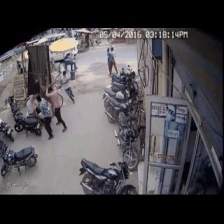

In [ ]:
to_gif(frames)

In [ ]:
# buat tf.data.Dataset
batch_size = 3

output_signature = (tf.TensorSpec(shape=(None, None, None, 3), dtype=tf.float32),
                    tf.TensorSpec(shape=(), dtype=tf.int16))

train_ds = tf.data.Dataset.from_generator(FrameGenerator(train_file, training=True),
                                          output_signature=output_signature)


test_ds = tf.data.Dataset.from_generator(FrameGenerator(test_file),
                                          output_signature=output_signature)


In [ ]:
train_ds = train_ds.batch(batch_size)
test_ds = test_ds.batch(batch_size)

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size = AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size = AUTOTUNE)

In [ ]:
# test data
for frames, labels in train_ds.take(10):
    print(labels)

print(f"Shape: {frames.shape}")
print(f"Label: {labels.shape}")

tf.Tensor([0 0 0], shape=(3,), dtype=int16)
tf.Tensor([1 1 1], shape=(3,), dtype=int16)
tf.Tensor([1 1 1], shape=(3,), dtype=int16)
tf.Tensor([0 1 0], shape=(3,), dtype=int16)
tf.Tensor([1 1 1], shape=(3,), dtype=int16)
tf.Tensor([0 1 0], shape=(3,), dtype=int16)
tf.Tensor([1 0 0], shape=(3,), dtype=int16)
tf.Tensor([0 1 0], shape=(3,), dtype=int16)
tf.Tensor([0 1 1], shape=(3,), dtype=int16)
tf.Tensor([0 0 1], shape=(3,), dtype=int16)
Shape: (3, 21, 224, 224, 3)
Label: (3,)


In [ ]:
# RESNET pretrained
pretrained_model = tf.keras.applications.ResNet50(include_top=False,
                                                  input_shape=(224, 224, 3),
                                                  pooling='avg',
                                                  weights='imagenet')

94765736/94765736 [==============================] - 3s 0us/step


In [ ]:
# buang avg pool layer
gap_layer_name = 'avg_pool'
gap_layer_index = None

for i, layer in enumerate(pretrained_model.layers):
    if layer.name == gap_layer_name:
        gap_layer_index = i
        break


if gap_layer_index is not None:
    model_without_gap = tf.keras.Model(inputs=pretrained_model.input, outputs=pretrained_model.layers[gap_layer_index - 1].output)

else:
    print("GAP layer not found.")

In [ ]:
video_input_shape = (21, 224, 224, 3)

video_input = tf.keras.Input(shape=video_input_shape)
time_distributed = TimeDistributed(model_without_gap)(video_input)

conv_lstm_output = ConvLSTM2D(filters=256, kernel_size=(3, 3), padding="same", return_sequences=True)(time_distributed)

mhsa_output = MultiHeadAttention(num_heads=8, key_dim=256, value_dim=256)(conv_lstm_output, conv_lstm_output)
# attention_time = TimeDistributed(tf.keras.layers.Lambda(lambda x: x))(mhsa_output)

conv_lstm_output2 = ConvLSTM2D(filters=256, kernel_size=(3, 3), padding="same", return_sequences=True)(mhsa_output)

maxpool3d = MaxPooling3D(pool_size=(1,2,2))(conv_lstm_output2)

flattened = Flatten()(maxpool3d)

dense_1 = Dense(1000, activation="relu")(flattened)
dense_2 = Dense(256, activation="relu")(dense_1)
dense_3 = Dense(10, activation="relu")(dense_2)
dense_4 = Dense(2, activation="softmax")(dense_3)

# Create the model
model = tf.keras.Model(inputs=video_input, outputs=dense_4)

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 21, 224, 224, 3)]    0         []                            
                                                                                                  
 time_distributed (TimeDist  (None, 21, 7, 7, 2048)       2358771   ['input_2[0][0]']             
 ributed)                                                 2                                       
                                                                                                  
 conv_lstm2d (ConvLSTM2D)    (None, 21, 7, 7, 256)        2123468   ['time_distributed[0][0]']    
                                                          8                                       
                                                                                            

In [ ]:
epochs = 20
lr = 1e-4

In [ ]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.RMSprop(learning_rate=lr),
              metrics=['accuracy'])

In [ ]:
checkpoint_filepath = 'model_checkpoint.h5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,  # Set to True if you only want to save weights
    save_freq='epoch',
    period=5  # Save every 5 epochs
)

In [ ]:
results = model.fit(train_ds,
                    validation_data=test_ds,
                    epochs=epochs,
                    validation_freq=1,
                    verbose=1, callbacks=[model_checkpoint_callback])

Epoch 1/10
134/134 [==============================] - 506s 3s/step - loss: 0.6925 - accuracy: 0.5150 - val_loss: 0.6929 - val_accuracy: 0.5500
Epoch 2/10
134/134 [==============================] - 209s 2s/step - loss: 0.6899 - accuracy: 0.5900 - val_loss: 0.6926 - val_accuracy: 0.6250
Epoch 3/10
134/134 [==============================] - 214s 2s/step - loss: 0.6832 - accuracy: 0.6975 - val_loss: 0.6840 - val_accuracy: 0.6500
Epoch 4/10
134/134 [==============================] - 224s 2s/step - loss: 0.6664 - accuracy: 0.7400 - val_loss: 0.6661 - val_accuracy: 0.7125
Epoch 5/10
134/134 [==============================] - 219s 2s/step - loss: 0.6278 - accuracy: 0.7800 - val_loss: 0.6308 - val_accuracy: 0.7625
Epoch 6/10
134/134 [==============================] - 212s 2s/step - loss: 0.5535 - accuracy: 0.8250 - val_loss: 0.5860 - val_accuracy: 0.7375
Epoch 7/10
134/134 [==============================] - 211s 2s/step - loss: 0.4469 - accuracy: 0.8800 - val_loss: 0.5530 - val_accuracy: 0.7125

In [ ]:
model.evaluate(test_ds, return_dict=True)

27/27 [==============================] - 10s 378ms/step - loss: 0.6414 - accuracy: 0.6875


{'loss': 0.6413900256156921, 'accuracy': 0.6875}

In [ ]:
# RESNET pretrained
pretrained_model = tf.keras.applications.ResNet50(include_top=False,
                                                  input_shape=(224, 224, 3),
                                                  pooling='avg',
                                                  weights='imagenet')

In [ ]:
# buang avg pool layer
gap_layer_name = 'avg_pool'
gap_layer_index = None

for i, layer in enumerate(pretrained_model.layers):
    if layer.name == gap_layer_name:
        gap_layer_index = i
        break


if gap_layer_index is not None:
    model_without_gap = tf.keras.Model(inputs=pretrained_model.input, outputs=pretrained_model.layers[gap_layer_index - 1].output)

else:
    print("GAP layer not found.")

In [ ]:
video_input_shape = (21, 224, 224, 3)

video_input = tf.keras.Input(shape=video_input_shape)
time_distributed = TimeDistributed(model_without_gap)(video_input)

conv_lstm_output = ConvLSTM2D(filters=256, kernel_size=(3, 3), padding="same", return_sequences=True)(time_distributed)

# mhsa_output = MultiHeadAttention(num_heads=8, key_dim=256, value_dim=256)(conv_lstm_output, conv_lstm_output)
# attention_time = TimeDistributed(tf.keras.layers.Lambda(lambda x: x))(mhsa_output)

# conv_lstm_output2 = ConvLSTM2D(filters=256, kernel_size=(3, 3), padding="same", return_sequences=True)(attention_time)

maxpool3d = MaxPooling3D(pool_size=(1,2,2))(conv_lstm_output)

flattened = Flatten()(maxpool3d)

dense_1 = Dense(1000, activation="relu")(flattened)
dense_2 = Dense(256, activation="relu")(dense_1)
dense_3 = Dense(10, activation="relu")(dense_2)
dense_4 = Dense(2, activation="softmax")(dense_3)

# Create the model
model = tf.keras.Model(inputs=video_input, outputs=dense_4)

model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 21, 224, 224, 3   0         
                             )]                                  
                                                                 
 time_distributed_1 (TimeDi  (None, 21, 7, 7, 2048)    23587712  
 stributed)                                                      
                                                                 
 conv_lstm2d_2 (ConvLSTM2D)  (None, 21, 7, 7, 256)     21234688  
                                                                 
 max_pooling3d_1 (MaxPoolin  (None, 21, 3, 3, 256)     0         
 g3D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 48384)             0         
                                                           

In [ ]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
              metrics=['accuracy'])

In [ ]:
checkpoint_filepath = 'model_checkpoint2.h5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,  # Set to True if you only want to save weights
    save_freq='epoch',
    period=5  # Save every 5 epochs
)

In [ ]:
results = model.fit(train_ds,
                    validation_data=test_ds,
                    epochs=epochs,
                    validation_freq=1,
                    verbose=1, callbacks=[model_checkpoint_callback])

Epoch 1/10
134/134 [==============================] - 232s 1s/step - loss: 0.6956 - accuracy: 0.5300 - val_loss: 0.6957 - val_accuracy: 0.5375
Epoch 2/10
134/134 [==============================] - 195s 1s/step - loss: 0.5494 - accuracy: 0.8025 - val_loss: 0.6694 - val_accuracy: 0.6125
Epoch 3/10
134/134 [==============================] - 196s 1s/step - loss: 0.3745 - accuracy: 0.9650 - val_loss: 0.6363 - val_accuracy: 0.6125
Epoch 4/10
134/134 [==============================] - 196s 1s/step - loss: 0.2498 - accuracy: 1.0000 - val_loss: 0.5735 - val_accuracy: 0.7625
Epoch 5/10
134/134 [==============================] - 214s 2s/step - loss: 0.1657 - accuracy: 1.0000 - val_loss: 0.6082 - val_accuracy: 0.6125
Epoch 6/10
134/134 [==============================] - 195s 1s/step - loss: 0.1106 - accuracy: 1.0000 - val_loss: 0.6093 - val_accuracy: 0.6375
Epoch 7/10
134/134 [==============================] - 195s 1s/step - loss: 0.0740 - accuracy: 1.0000 - val_loss: 0.6093 - val_accuracy: 0.6750

In [ ]:
model.evaluate(test_ds, return_dict=True)